In [38]:
from statsmodels.regression.rolling import RollingOLS
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from datetime import datetime, date
warnings.filterwarnings('ignore')

# Get SPY Data

In [23]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    "User-Agent": "Chrome/117.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)

In [26]:
df_list = pd.read_html(response.text)
sp500 = df_list[0]

In [29]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

In [45]:
end_date = datetime.now().strftime('%Y-%m-%d')
end_date = pd.to_datetime(end_date)

start_date = end_date - pd.DateOffset(365*8)

In [61]:
start_date

Timestamp('2017-10-21 00:00:00')

In [62]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

[*********************100%***********************]  503 of 503 completed


In [63]:
df = df.stack()
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

In [64]:
df

Price                   close        high         low        open      volume
date       ticker                                                            
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0
...                       ...         ...         ...         ...         ...
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0

[991317 rows x 5 columns]

# Calculate features and technical indicators for each stock

## Garman-Klass Volaitlity

In [65]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['close']))-np.log(df['open'])**2)

In [66]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol  
date       ticker                    
2017-10-23 A               5.055272  
           AAPL            3.620730  
           ABBV            5.259514  
           ABT             4.339849  
           ACGL            3.321990  
...                             ...  
2025-10-17 XYZ             5.477835  
           YUM             7.612033  
           ZBH             6.400124  
           ZBRA           10.267846  
           ZTS             7.597975  

[991317 rows x 6 columns]

In [67]:
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

In [68]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol        rsi  
date       ticker                               
2017-10-23 A               5.055272        NaN  
           AAPL            3.620730        NaN  
           ABBV            5.259514        NaN  
           ABT             4.339849        NaN  
           ACGL            3.321990        NaN  
...                             ...        ...  
2025-10-17 XYZ             5.477835  48.793354  
           YUM             7.612033  47.586128  
           ZBH             6.400124  55.314439  
           ZBRA           10.267846  45.087533  
           ZTS             7.597975  45.064732  

[991317 rows x 7 columns]

<Axes: xlabel='date'>

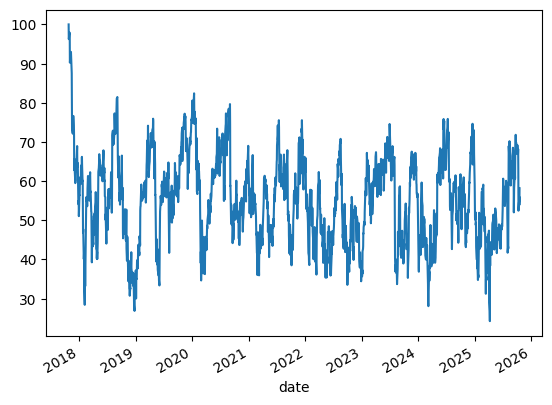

In [69]:
df.xs('AAPL', level=1)['rsi'].plot()

# Bollinger bands

In [71]:
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_upper'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [72]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  
date       ticker                                                             
2017-10-23 A               5.055272        NaN       NaN       NaN       NaN  
           AAPL            3.620730        NaN       NaN       NaN       NaN  
           ABBV            5.259514        NaN       NaN       NaN       NaN  
           ABT             4.339849        NaN       NaN       NaN       NaN  
           ACGL            3.321990        NaN       NaN       NaN       NaN  
...                             ...        ...       ...       ...       ...  
2025-10-17 XYZ             5.477835  48.793354  4.285518  4.345395  4.405272  
           YUM             7.612033  47.586128  4.946976  5.002198  5.057420  
           ZBH             6.400124  55.314439  4.565185  4.601706  4.638227  
           ZBRA           10.267846  45.087533  5.634694  5.699691  5.764688  
           ZTS             7.597975  45.064732  4.949855  4.974617  4.999380  

[991317 rows x 10 columns]

# ATR

In [75]:
def calculate_atr(stock_data):
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14
    )

    return atr.sub(atr.mean()).div(atr.std())

In [76]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(calculate_atr)
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-23 A               5.055272        NaN       NaN       NaN       NaN   
           AAPL            3.620730        NaN       NaN       NaN       NaN   
           ABBV            5.259514        NaN       NaN       NaN       NaN   
           ABT             4.339849        NaN       NaN       NaN       NaN   
           ACGL            3.321990        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-17 XYZ             5.477835  48.793354  4.285518  4.345395  4.405272   
           YUM             7.612033  47.586128  4.946976  5.002198  5.057420   
           ZBH             6.400124  55.314439  4.565185  4.601706  4.638227   
           ZBRA           10.267846  45.087533  5.634694  5.699691  5.764688   
           ZTS             7.597975  45.064732  4.949855  4.974617  4.999380   

Price                   atr  
date       ticker            
2017-10-23 A            NaN  
           AAPL         NaN  
           ABBV         NaN  
           ABT          NaN  
           ACGL         NaN  
...                     ...  
2025-10-17 XYZ    -0.584438  
           YUM     1.074224  
           ZBH    -0.488887  
           ZBRA    0.243370  
           ZTS    -0.411411  

[991317 rows x 11 columns]

# MACD

In [78]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    
    return macd.sub(macd.mean()).div(macd.std())

In [79]:
df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

In [80]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-23 A               5.055272        NaN       NaN       NaN       NaN   
           AAPL            3.620730        NaN       NaN       NaN       NaN   
           ABBV            5.259514        NaN       NaN       NaN       NaN   
           ABT             4.339849        NaN       NaN       NaN       NaN   
           ACGL            3.321990        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-17 XYZ             5.477835  48.793354  4.285518  4.345395  4.405272   
           YUM             7.612033  47.586128  4.946976  5.002198  5.057420   
           ZBH             6.400124  55.314439  4.565185  4.601706  4.638227   
           ZBRA           10.267846  45.087533  5.634694  5.699691  5.764688   
           ZTS             7.597975  45.064732  4.949855  4.974617  4.999380   

Price                   atr      macd  
date       ticker                      
2017-10-23 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-10-17 XYZ    -0.584438 -0.030591  
           YUM     1.074224 -0.943980  
           ZBH    -0.488887 -0.165229  
           ZBRA    0.243370 -0.746836  
           ZTS    -0.411411 -0.701974  

[991317 rows x 12 columns]

# Dollar volume

In [81]:
df['dollar_volume'] = (df['close']*df['volume'])/1e6

In [82]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-23 A        63.094593   63.715940   63.009868   63.499408   1267600.0   
           AAPL     36.478062   36.833103   36.321564   36.646239  87937200.0   
           ABBV     67.131393   68.189754   67.088771   68.140032   4483900.0   
           ABT      48.725777   49.255780   48.717086   48.838726   4709000.0   
           ACGL     32.450996   32.520729   32.222779   32.314701   1266900.0   
...                       ...         ...         ...         ...         ...   
2025-10-17 XYZ      75.199997   75.709999   73.379997   73.779999   4416700.0   
           YUM     145.250000  146.240005  143.220001  143.770004   1503100.0   
           ZBH     101.919998  102.099998   99.059998   99.820000   1158700.0   
           ZBRA    293.309998  295.420013  290.690002  292.920013    413000.0   
           ZTS     144.059998  144.570007  142.550003  143.130005   3748900.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-23 A               5.055272        NaN       NaN       NaN       NaN   
           AAPL            3.620730        NaN       NaN       NaN       NaN   
           ABBV            5.259514        NaN       NaN       NaN       NaN   
           ABT             4.339849        NaN       NaN       NaN       NaN   
           ACGL            3.321990        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-17 XYZ             5.477835  48.793354  4.285518  4.345395  4.405272   
           YUM             7.612033  47.586128  4.946976  5.002198  5.057420   
           ZBH             6.400124  55.314439  4.565185  4.601706  4.638227   
           ZBRA           10.267846  45.087533  5.634694  5.699691  5.764688   
           ZTS             7.597975  45.064732  4.949855  4.974617  4.999380   

Price                   atr      macd  dollar_volume  
date       ticker                                     
2017-10-23 A            NaN       NaN      79.978706  
           AAPL         NaN       NaN    3207.778605  
           ABBV         NaN       NaN     301.010455  
           ABT          NaN       NaN     229.449682  
           ACGL         NaN       NaN      41.112167  
...                     ...       ...            ...  
2025-10-17 XYZ    -0.584438 -0.030591     332.135827  
           YUM     1.074224 -0.943980     218.325275  
           ZBH    -0.488887 -0.165229     118.094702  
           ZBRA    0.243370 -0.746836     121.137029  
           ZTS    -0.411411 -0.701974     540.066525  

[991317 rows x 13 columns]